In [16]:
import pandas as pd
import numpy as np

import os

%pylab inline

os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

Populating the interactive namespace from numpy and matplotlib


C:\Users\Vince\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [38]:
data = pd.read_csv('Magic record - Sheet1.csv')

data.tail()

,Me,Opponent,Win,Rank
135,WUR,BR,0,Silver 4
136,WUR,WU,1,Silver 4
137,WUR,WU,0,Silver 4
138,WG,WG,1,Silver 4
139,WG,UR,1,Silver 4


In [39]:
data.groupby('Me').count()

,Opponent,Win,Rank
Me,,,
BG,14,14,14
BR,9,9,9
G,4,4,4
R,11,11,11
RG,12,12,12
UB,18,18,18
UBR,6,6,6
UG,17,17,17
UR,11,11,11


In [40]:
data['Me_W'] = np.where(data['Me'].str.contains('W'), 1, 0)
data['Me_U'] = np.where(data['Me'].str.contains('U'), 1, 0)
data['Me_B'] = np.where(data['Me'].str.contains('B'), 1, 0)
data['Me_R'] = np.where(data['Me'].str.contains('R'), 1, 0)
data['Me_G'] = np.where(data['Me'].str.contains('G'), 1, 0)

data['Opponent_W'] = np.where(data['Opponent'].str.contains('W'), 1, 0)
data['Opponent_U'] = np.where(data['Opponent'].str.contains('U'), 1, 0)
data['Opponent_B'] = np.where(data['Opponent'].str.contains('B'), 1, 0)
data['Opponent_R'] = np.where(data['Opponent'].str.contains('R'), 1, 0)
data['Opponent_G'] = np.where(data['Opponent'].str.contains('G'), 1, 0)

rank = np.where(data['Rank'] == 'Bronze 1', 1, np.nan)
rank = np.where(data['Rank'] == 'Silver 4', 2, rank)
rank = np.where(data['Rank'] == 'Silver 3', 3, rank)

data['Rank'] = pd.Series(rank)

In [41]:
data.groupby('Me').mean()['Win'].sort_values()

Me
W      0.000000
UR     0.272727
UBR    0.333333
WUR    0.333333
UG     0.411765
BG     0.428571
G      0.500000
WB     0.500000
BR     0.555556
WG     0.695652
R      0.727273
RG     0.750000
UB     0.833333
Name: Win, dtype: float64

In [42]:
data.groupby('Opponent').mean()['Win'].sort_values()

Opponent
WR     0.000000
UG     0.000000
BG     0.400000
BR     0.400000
RG     0.400000
UR     0.400000
W      0.416667
WU     0.428571
WUG    0.500000
BRG    0.500000
U      0.500000
WUB    0.500000
WB     0.500000
G      0.533333
R      0.555556
UB     0.666667
B      0.714286
UBG    0.750000
WBR    1.000000
WG     1.000000
BW     1.000000
UW     1.000000
UBR    1.000000
Name: Win, dtype: float64

In [43]:
del data['Me']
del data['Opponent']

data = pd.get_dummies(data)

In [44]:
x = data.drop('Win', axis=1)
y = data['Win']

In [45]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

clf = DecisionTreeClassifier()
kf = StratifiedKFold(n_splits=3)

param_grid = {
    'max_depth': np.arange(2,7),
    'min_samples_leaf': np.arange(1,13),
    'min_samples_split': np.arange(2,13),
    
}

grid = GridSearchCV(clf, param_grid, cv=kf, scoring='roc_auc').fit(x, y)
clf = grid.best_estimator_

clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=3,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [46]:
cv = cross_val_score(clf, x, y, cv=kf, scoring='roc_auc')

cv.mean(), cv.std()

(0.466019536019536, 0.08244360643718521)

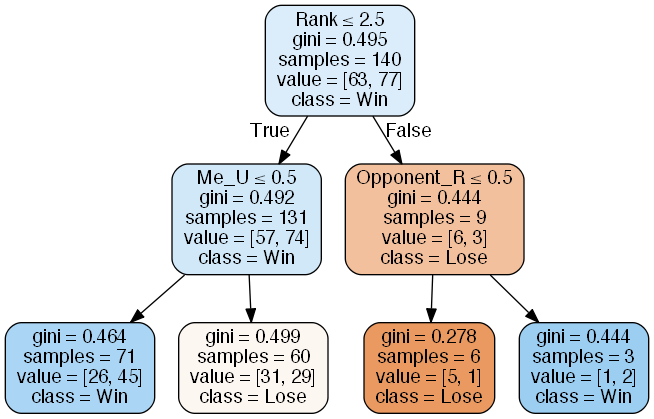

In [47]:
from sklearn.tree import export_graphviz

clf = DecisionTreeClassifier(max_depth=2)
clf = clf.fit(x,y)
from IPython.display import Image  
import pydotplus

dot_data = export_graphviz(clf, out_file=None, 
                         feature_names=x.columns,  
                         class_names=['Lose', 'Win'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

clf = LogisticRegression()
kf = StratifiedKFold()

param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [.0001, .001, .01, .1, 1, 2, .5]
}

grid = GridSearchCV(clf, param_grid, cv=kf, scoring='roc_auc').fit(x, y)
clf = grid.best_estimator_

clf

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [49]:
cv = cross_val_score(clf, x, y, cv=kf, scoring='roc_auc')

cv.mean(), cv.std()

(0.5, 0.0)

In [50]:
pd.DataFrame(clf.coef_, columns=x.columns).T.sort_values(0)

,0
Rank,0.0
Me_W,0.0
Me_U,0.0
Me_B,0.0
Me_R,0.0
Me_G,0.0
Opponent_W,0.0
Opponent_U,0.0
Opponent_B,0.0
Opponent_R,0.0


In [51]:
data.to_csv('record_proc.csv')